From https://learn.astropy.org/tutorials/Models-Quick-Fit.html

install the needed packages

In [7]:
pip install matplotlib astroquery

Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from astroquery.vizier import Vizier
import scipy.optimize
# Make plots display in notebooks
%matplotlib inline 

We are going to start with a linear fit to real data. The data comes from the paper Bhardwaj et al. 2017. This is a catalog of Type II Cepheids, which is a type of variable stars that pulsate with a period between 1 and 50 days. In this part of the tutorial, we are going to measure the Cepheids Period-Luminosity relation using astropy.modeling. This relation states that if a star has a longer period, the luminosity we measure is higher.

To get it, we are going to import it from Vizier using astroquery.

In [12]:
catalog = Vizier.get_catalogs('J/A+A/605/A100')

In [13]:
period = np.array(catalog[0]['Period']) 
log_period = np.log10(period)
k_mag = np.array(catalog[0]['__Ksmag_'])
k_mag_err = np.array(catalog[0]['e__Ksmag_'])

Text(0, 0.5, 'Ks')

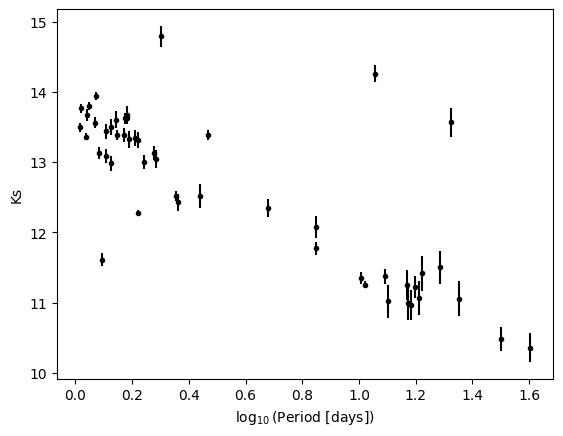

In [14]:
plt.errorbar(log_period, k_mag, k_mag_err, fmt='k.')
plt.xlabel(r'$\log_{10}$(Period [days])')
plt.ylabel('Ks')

Ok, now we want to fit  a curve to the above data. The process is as follows:
   * Choose a model
   * Choose a fitter
   * Fit the model/fitter to the data - Perform the fit and see what you get
   
We start with a linear 1D fit (easiest first)

In [15]:
model = models.Linear1D();
fitter = fitting.LinearLSQFitter();
best_fit = fitter(model, log_period, k_mag, weights=1.0/k_mag_err**2)
print(best_fit)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
           slope            intercept     
    ------------------- ------------------
    -2.0981402575088954 13.418358846900368


Text(0, 0.5, 'Ks')

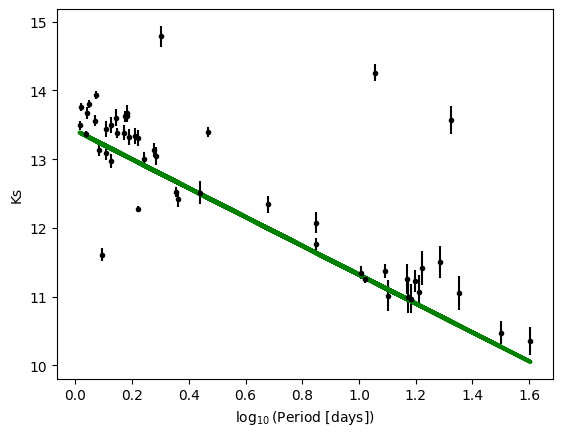

In [16]:
plt.errorbar(log_period,k_mag,k_mag_err,fmt='k.')
plt.plot(log_period, best_fit(log_period), color='g', linewidth=3)  
plt.xlabel(r'$\log_{10}$(Period [days])')
plt.ylabel('Ks')

Now we try a polynomial fit

Text(0, 0.5, '$y_1$')

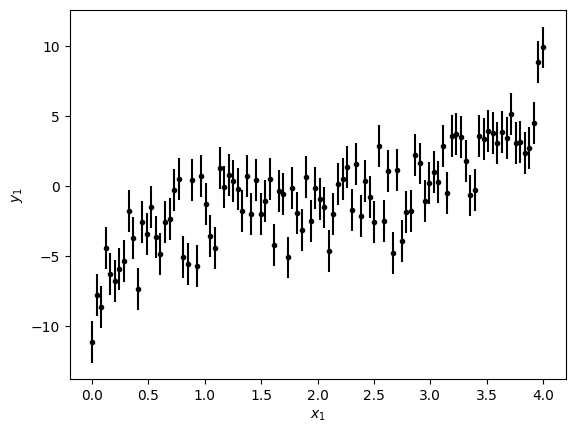

In [17]:
N = 100
x1 = np.linspace(0, 4, N)  # Makes an array from 0 to 4 of N elements
y1 = x1**3 - 6*x1**2 + 12*x1 - 9 
# Now we add some noise to the data
y1 += np.random.normal(0, 2, size=len(y1)) #One way to add random gaussian noise
sigma = 1.5
y1_err = np.ones(N)*sigma 

plt.errorbar(x1, y1, yerr=y1_err,fmt='k.')
plt.xlabel('$x_1$')  
plt.ylabel('$y_1$')

now let's pick the model and the fitter

In [18]:
model_poly = models.Polynomial1D(degree=3)
fitter_poly = fitting.LinearLSQFitter() 
best_fit_poly = fitter_poly(model_poly, x1, y1, weights = 1.0/y1_err**2)

print(best_fit_poly)


Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
            c0                 c1                c2                c3        
    ------------------ ----------------- ----------------- ------------------
    -7.992358771962255 10.92613915488855 -5.59002106577856 0.9504343111446502


In [19]:
fitter_poly_2 = fitting.SimplexLSQFitter()
best_fit_poly_2 = fitter_poly_2(model_poly, x1, y1, weights = 1.0/y1_err**2)
print(best_fit_poly_2)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
             c0                  c1                  c2                 c3        
    ------------------- ------------------- ------------------- ------------------
    0.26638104813586816 0.04484445234340671 -1.0306968268200407 0.3500566964025783


compare the 2 models.fitters

In [20]:
def calc_reduced_chi_square(fit, x, y, yerr, N, n_free):
    '''
    fit (array) values for the fit
    x,y,yerr (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    '''
    return 1.0/(N-n_free)*sum(((fit - y)/yerr)**2)

In [21]:
reduced_chi_squared = calc_reduced_chi_square(best_fit_poly(x1), x1, y1, y1_err, N, 4)
print('Reduced Chi Squared with LinearLSQFitter: {}'.format(reduced_chi_squared))

Reduced Chi Squared with LinearLSQFitter: 1.741443580311517


In [22]:
reduced_chi_squared = calc_reduced_chi_square(best_fit_poly_2(x1), x1, y1, y1_err, N, 4)
print('Reduced Chi Squared with SimplexLSQFitter: {}'.format(reduced_chi_squared))

Reduced Chi Squared with SimplexLSQFitter: 4.425458610736985


as the notes from the tutorial state, since the reduced chi squared error is closer to 1 for the LinearLSQFitter, it is superior to the SimplexLSQFitter. 

Visually, you can see this too

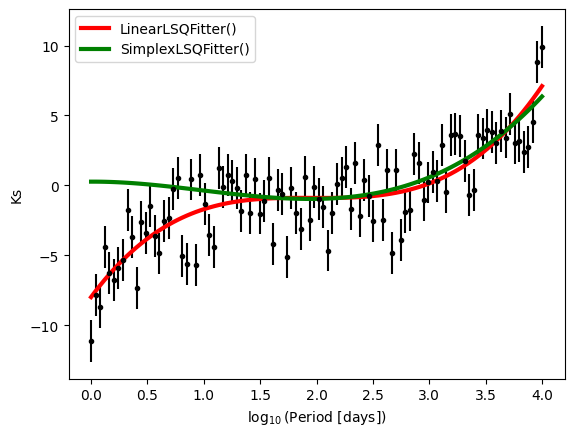

In [23]:
plt.errorbar(x1, y1, yerr=y1_err,fmt='k.')
plt.plot(x1, best_fit_poly(x1), color='r', linewidth=3, label='LinearLSQFitter()')  
plt.plot(x1, best_fit_poly_2(x1), color='g', linewidth=3, label='SimplexLSQFitter()')
plt.xlabel(r'$\log_{10}$(Period [days])')
plt.ylabel('Ks')
plt.legend()

Exercise 3: Fit a gaussian curve and compare the fit provided by astropy models to the fit provided by scipy.optimize.curve_fit

Text(0, 0.5, '$y_2$')

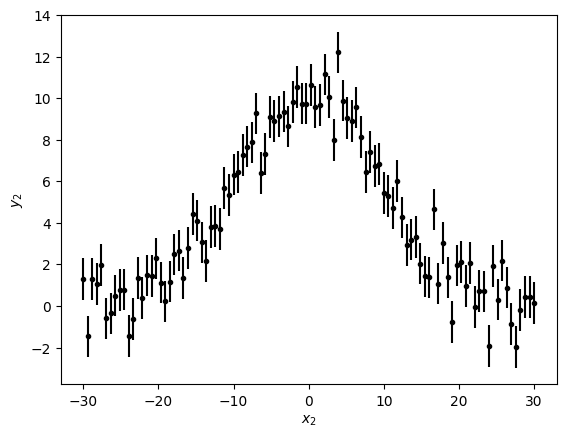

In [24]:
mu, sigma, amplitude = 0.0, 10.0, 10.0
N2 = 100
x2 = np.linspace(-30, 30, N)
y2 = amplitude * np.exp(-(x2-mu)**2 / (2*sigma**2))
y2 = np.array([y_point + np.random.normal(0, 1) for y_point in y2])   #Another way to add random gaussian noise
sigma = 1
y2_err = np.ones(N)*sigma

plt.errorbar(x2, y2, yerr=y2_err, fmt='k.')
plt.xlabel('$x_2$')
plt.ylabel('$y_2$')

In [27]:
model_gauss = models.Gaussian1D()
fitter_gauss = fitting.LevMarLSQFitter()
best_fit_gauss = fitter_gauss(model_gauss, x2, y2, weights=1/y2_err**2)
                              
print(best_fit_gauss)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev     
    ------------------ ------------------- -----------------
    10.256174161226138 0.07399826378717574 9.515514019437209


In [28]:
model_gauss.param_names

('amplitude', 'mean', 'stddev')

In [29]:
cov_diag = np.diag(fitter_gauss.fit_info['param_cov'])
print(cov_diag)

print('Amplitude: {} +\- {}'.format(best_fit_gauss.amplitude.value, np.sqrt(cov_diag[0])))
print('Mean: {} +\- {}'.format(best_fit_gauss.mean.value, np.sqrt(cov_diag[1])))
print('Standard Deviation: {} +\- {}'.format(best_fit_gauss.stddev.value, np.sqrt(cov_diag[2])))

[0.05512595 0.06325462 0.06334081]
Amplitude: 10.256174161226138 +\- 0.23478915846314163
Mean: 0.07399826378717574 +\- 0.25150472073084335
Standard Deviation: 9.515514019437209 +\- 0.25167601029479686


Compare the two different gaussian models.fitters

In [32]:
reduced_chi_squared = calc_reduced_chi_square(best_fit_gauss(x2), x2, y2, y2_err, N2, 3)
print('Reduced Chi Squared using astropy.modeling: {}'.format(reduced_chi_squared))

Reduced Chi Squared using astropy.modeling: 1.0223101673253565


In [33]:
def f(x,a,b,c):
    return a * np.exp(-(x-b)**2/(2.0*c**2))

In [34]:
p_opt, p_cov = scipy.optimize.curve_fit(f,x2, y2, sigma=y1_err)
a,b,c = p_opt
best_fit_gauss_2 = f(x2,a,b,c)
print(p_opt)

[10.25617451  0.07399724  9.51551337]


In [35]:
reduced_chi_squared = calc_reduced_chi_square(best_fit_gauss_2, x2, y2, y2_err, N2, 3)
print('Reduced Chi Squared using scipy: {}'.format(reduced_chi_squared))

Reduced Chi Squared using scipy: 1.0223101673277837


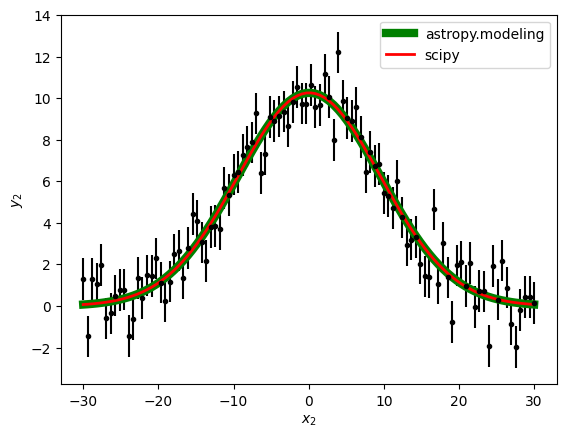

In [36]:
plt.errorbar(x2, y2, yerr=y2_err, fmt='k.')
plt.plot(x2, best_fit_gauss(x2), 'g-', linewidth=6, label='astropy.modeling')
plt.plot(x2, best_fit_gauss_2, 'r-', linewidth=2, label='scipy')
plt.xlabel('$x_2$')
plt.ylabel('$y_2$')
plt.legend()

Exercise: Play on your own - finding your own fit

In [39]:
N3 = 100
x3 = np.linspace(0, 3, N3)
y3 = 5.0 * np.sin(2 * np.pi * x3)
y3_data = np.array([y_point + np.random.normal(0, 1) for y_point in y3])
sigma = 1.5
y3_err = np.ones(N)*sigma 

Text(0, 0.5, '$y_3$')

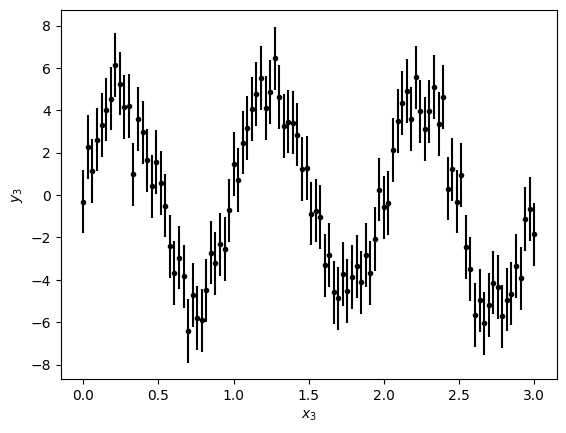

In [42]:
plt.errorbar(x3, y3_data, yerr=y3_err, fmt='k.')
plt.xlabel('$x_3$')
plt.ylabel('$y_3$')

In [45]:
models

<module 'astropy.modeling.models' from '/opt/homebrew/Cellar/jupyterlab/3.6.1/libexec/lib/python3.11/site-packages/astropy/modeling/models.py'>

/var/folders/wy/m5nnf_yn1ggbyzfbwkchqpl40000gn/T/ipykernel_95653/2628254407.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(x3, y3_data, yerr=y3_err, color='gray', fmt='k.', label='raw data')


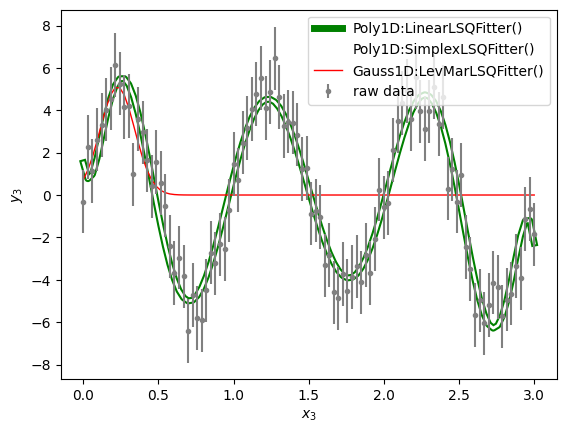

In [77]:
model_poly_b = models.Polynomial1D(degree=9)
fitter_poly_b = fitting.LinearLSQFitter() 
best_fit_poly_b = fitter_poly_b(model_poly_b, x3, y3_data, weights = 1.0/y3_err**2)

model_gauss_b = models.Gaussian1D()
fitter_gauss_b = fitting.LevMarLSQFitter()
best_fit_gauss_b = fitter_gauss_b(model_gauss_b, x3, y3_data, weights=1/y3_err**2)

fitter_poly_2_b = fitting.SimplexLSQFitter()
best_fit_poly_2_b = fitter_poly_2_b(model_poly_b, x3, y3_data, weights = 1.0/y1_err**2)

plt.plot(x3, best_fit_poly_b(x3), 'g-', linewidth=5, label='Poly1D:LinearLSQFitter()')
plt.plot(x3, best_fit_poly_b(x3), 'w-', linewidth=2, label='Poly1D:SimplexLSQFitter()')
plt.plot(x3, best_fit_gauss_b(x3), 'r-', linewidth=1, label='Gauss1D:LevMarLSQFitter()')
plt.errorbar(x3, y3_data, yerr=y3_err, color='gray', fmt='k.', label='raw data')
plt.xlabel('$x_3$')
plt.ylabel('$y_3$')
plt.legend()